# LangSmith and Evaluation Overview with AI Makerspace

Today we'll be looking at an amazing tool:

[LangSmith](https://docs.smith.langchain.com/)!

This tool will help us monitor, test, debug, and evaluate our LangChain applications - and more!

We'll also be looking at a few Advanced Retrieval techniques along the way - and evaluate it using LangSmith!

✋BREAKOUT ROOM #2:
- Task 1: Dependencies and OpenAI API Key
- Task 2: LangGraph RAG
- Task 3: Setting Up LangSmith
- Task 4: Examining the Trace in LangSmith!
- Task 5: Create Testing Dataset
- Task 6: Evaluation

## Task 1: Dependencies and OpenAI API Key

We'll be using OpenAI's suite of models today to help us generate and embed our documents for our simple RAG system that leverages Loand Complaint data.

In [1]:
import os
import openai
from dotenv import load_dotenv

load_dotenv()
openai.api_key = os.getenv("OPENAI_API_KEY")

In [2]:
# import os
# import getpass

# os.environ["OPENAI_API_KEY"] = getpass.getpass("Enter your OpenAI API Key:")

#### Asyncio Bug Handling

In [3]:
import nest_asyncio
nest_asyncio.apply()

## Task #2: Create a Simple RAG Application Using LangGraph

Let's remake our LangGraph RAG pipeline from the first notebook!

## LangGraph Powered RAG

First and foremost, LangChain provides a convenient way to store our chunks and their embeddings.

It's called a `VectorStore`!

We'll be using QDrant as our `VectorStore` today. You can read more about it [here](https://qdrant.tech/documentation/).

Think of a `VectorStore` as a smart way to house your chunks and their associated embedding vectors. The implementation of the `VectorStore` also allows for smarter and more efficient search of our embedding vectors - as the method we used above would not scale well as we got into the millions of chunks.

Otherwise, the process remains relatively similar under the hood!

### Data Collection

We'll be leveraging the `DirectoryLoader` to load our PDFs!

In [4]:
from langchain_community.document_loaders import DirectoryLoader
from langchain_community.document_loaders import PyMuPDFLoader

directory_loader = DirectoryLoader("data", glob="**/*.pdf", loader_cls=PyMuPDFLoader)

loan_knowledge_resources = directory_loader.load()

### Chunking Our Documents

Let's do the same process as we did before with our `RecursiveCharacterTextSplitter` - but this time we'll use ~200 tokens as our max chunk size!

In [5]:
import tiktoken
from langchain.text_splitter import RecursiveCharacterTextSplitter

def tiktoken_len(text):
    tokens = tiktoken.encoding_for_model("gpt-4o").encode(
        text,
    )
    return len(tokens)

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size = 750,
    chunk_overlap = 0,
    length_function = tiktoken_len,
)
loan_knowledge_chunks = text_splitter.split_documents(loan_knowledge_resources)

In [6]:
len(loan_knowledge_chunks)

375

Let's verify the process worked as intended by checking our max document length.

In [7]:
max_chunk_length = 0

for chunk in loan_knowledge_chunks:
  max_chunk_length = max(max_chunk_length, tiktoken_len(chunk.page_content))

print(max_chunk_length)

742


Perfect! Now we can carry on to creating and storing our embeddings.

### Embeddings and Vector Storage

We'll use the `text-embedding-3-small` embedding model again - and `Qdrant` to store all our embedding vectors for easy retrieval later!

In [8]:
from langchain_community.vectorstores import Qdrant
from langchain_openai.embeddings import OpenAIEmbeddings

embedding_model = OpenAIEmbeddings(model="text-embedding-3-small")

qdrant_vectorstore = Qdrant.from_documents(
    documents=loan_knowledge_chunks,
    embedding=embedding_model,
    location=":memory:"
)

Now let's set up our retriever, just as we saw before, but this time using LangChain's simple `as_retriever()` method!

In [9]:
qdrant_retriever = qdrant_vectorstore.as_retriever()

#### Back to the Flow

We're ready to move to the next step!

### Setting up our RAG

We'll use the same LangGraph pipeline we created in the first notebook. 

Let's think through each part:

1. First we need to retrieve context
2. We need to pipe that context to our model
3. We need to parse that output

Let's start by setting up our prompt again, just so it's fresh in our minds!

#### 🏗️ Activity #2:

Complete the prompt so that your RAG application answers queries based on the context provided, but *does not* answer queries if the context is unrelated to the query.

In [10]:
from langchain_core.prompts import ChatPromptTemplate

HUMAN_TEMPLATE = """
#CONTEXT:
{context}

QUERY:
{query}

Use the provide context to answer the provided user query. Only use the provided context to answer the query. If the answer is not contained in the provided context respond "I cannot answer because I have not found relevant context"
"""

chat_prompt = ChatPromptTemplate.from_messages([
    ("human", HUMAN_TEMPLATE)
])

We'll set our Generator - `gpt-4.1-nano` in this case - below!

In [12]:
from langchain_openai import ChatOpenAI

openai_chat_model = ChatOpenAI(model="gpt-4.1-nano")

#### Our RAG Application

Let's spin up the graph.

In [13]:
from langgraph.graph import START, StateGraph
from typing_extensions import TypedDict
from langchain_core.documents import Document
from langchain_core.output_parsers import StrOutputParser

class State(TypedDict):
  question: str
  context: list[Document]
  response: str

def retrieve(state: State) -> State:
  retrieved_docs = qdrant_retriever.invoke(state["question"])
  return {"context" : retrieved_docs}

def generate(state: State) -> State:
  generator_chain = chat_prompt | openai_chat_model | StrOutputParser()
  response = generator_chain.invoke({"query" : state["question"], "context" : state["context"]})
  return {"response" : response}

graph_builder = StateGraph(State)
graph_builder = graph_builder.add_sequence([retrieve, generate])
graph_builder.add_edge(START, "retrieve")
rag_graph = graph_builder.compile()

Let's get a visual understanding of our chain!

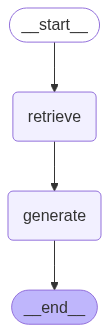

In [14]:
rag_graph

Let's test our chain out!

In [15]:
response = rag_graph.invoke({"question" : "Is applying for and securing a student loan in 2025 a terrible idea?"})

In [16]:
response["response"]

'I cannot answer the query because I have not found relevant context.'

In [17]:
for context in response["context"]:
  print("Context:")
  print(context.page_content[:100])
  print("----")

Context:
student to earn that number of credits. For instance, if your school has a baccalaureate program tha
----
Context:
You must confirm that the borrower meets the definition of eligible borrower by doing the following:
----
Context:
Regardless of the counseling methods your school uses, it must document that the student received en
----
Context:
Pell Grant Lifetime Eligibility Used
Before awarding a Pell Grant, you must check the COD common rec
----


Let's see if it can handle a query that is totally unrelated to the source documents.

In [18]:
response = rag_graph.invoke({"question" : "What is the airspeed velocity of an unladen swallow?"})

In [19]:
response["response"]

'I cannot answer the query because I have not found relevant context.'

## Task 3: Setting Up LangSmith

Now that we have a chain - we're ready to get started with LangSmith!

We're going to go ahead and use the following `env` variables to get our Colab notebook set up to start reporting.

If all you needed was simple monitoring - this is all you would need to do!

In [25]:
from uuid import uuid4

unique_id = uuid4().hex[0:8]

os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_PROJECT"] = f"LangSmith - {unique_id}"

### LangSmith API

In order to use LangSmith - you will need an API key. You can sign up for a free account on [LangSmith's homepage!](https://www.langchain.com/langsmith)

Once you have created your account, Take the navigation option for `Settings` then `API Keys` to create an API key.

In [26]:
import getpass
os.environ["LANGSMITH_API_KEY"] = getpass.getpass('Enter your LangSmith API key: ')

Enter your LangSmith API key:  ········


Let's test our our first generation!

In [24]:
rag_graph.invoke({"question" : "What is the maximum loan amount I can get from the government to go to school these days?"}, {"tags" : ["Demo Run"]})['response']

'Based on the provided context, the maximum loan amount you can receive from the government depends on your status and the specific program.\n\nFor dependent first-year undergraduates enrolled in a 900 clock-hour program, the maximum combined subsidized and unsubsidized loan limit for an academic year is $5,500, with no more than $3,500 subsidized. For students progressing to higher grade levels during an academic year, the limits can increase accordingly, up to a maximum of $7,500 combined for third-year students and beyond, with up to $5,500 subsidized.\n\nFor dependent students in a 900 clock-hour program who meet graduation requirements early (after completing 750 hours), the loan limit may be prorated, and the total could be approximately $4,583, with no more than approximately $2,917 subsidized.\n\nIn general, the total aggregate limits for federal loans are:\n- Up to $31,000 for dependent undergraduates (with a maximum of $23,000 subsidized)\n- Up to $57,500 for independent unde

## Task 4: Examining the Trace in LangSmith!

Head on over to your LangSmith web UI to check out how the trace looks in LangSmith!

#### 🏗️ Activity #1:

Include a screenshot of your trace and explain what it means.

<!-- 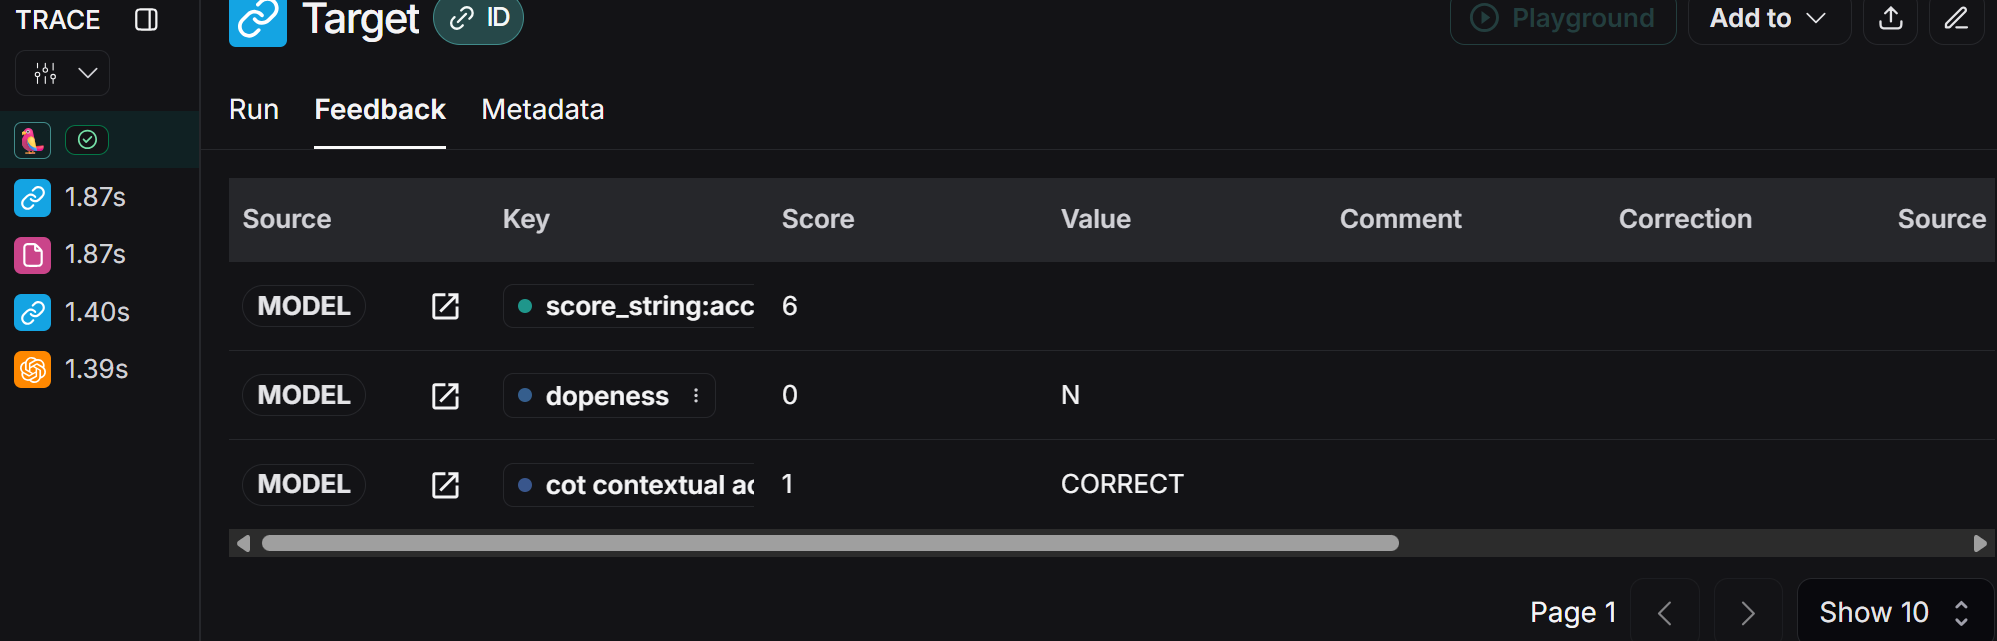
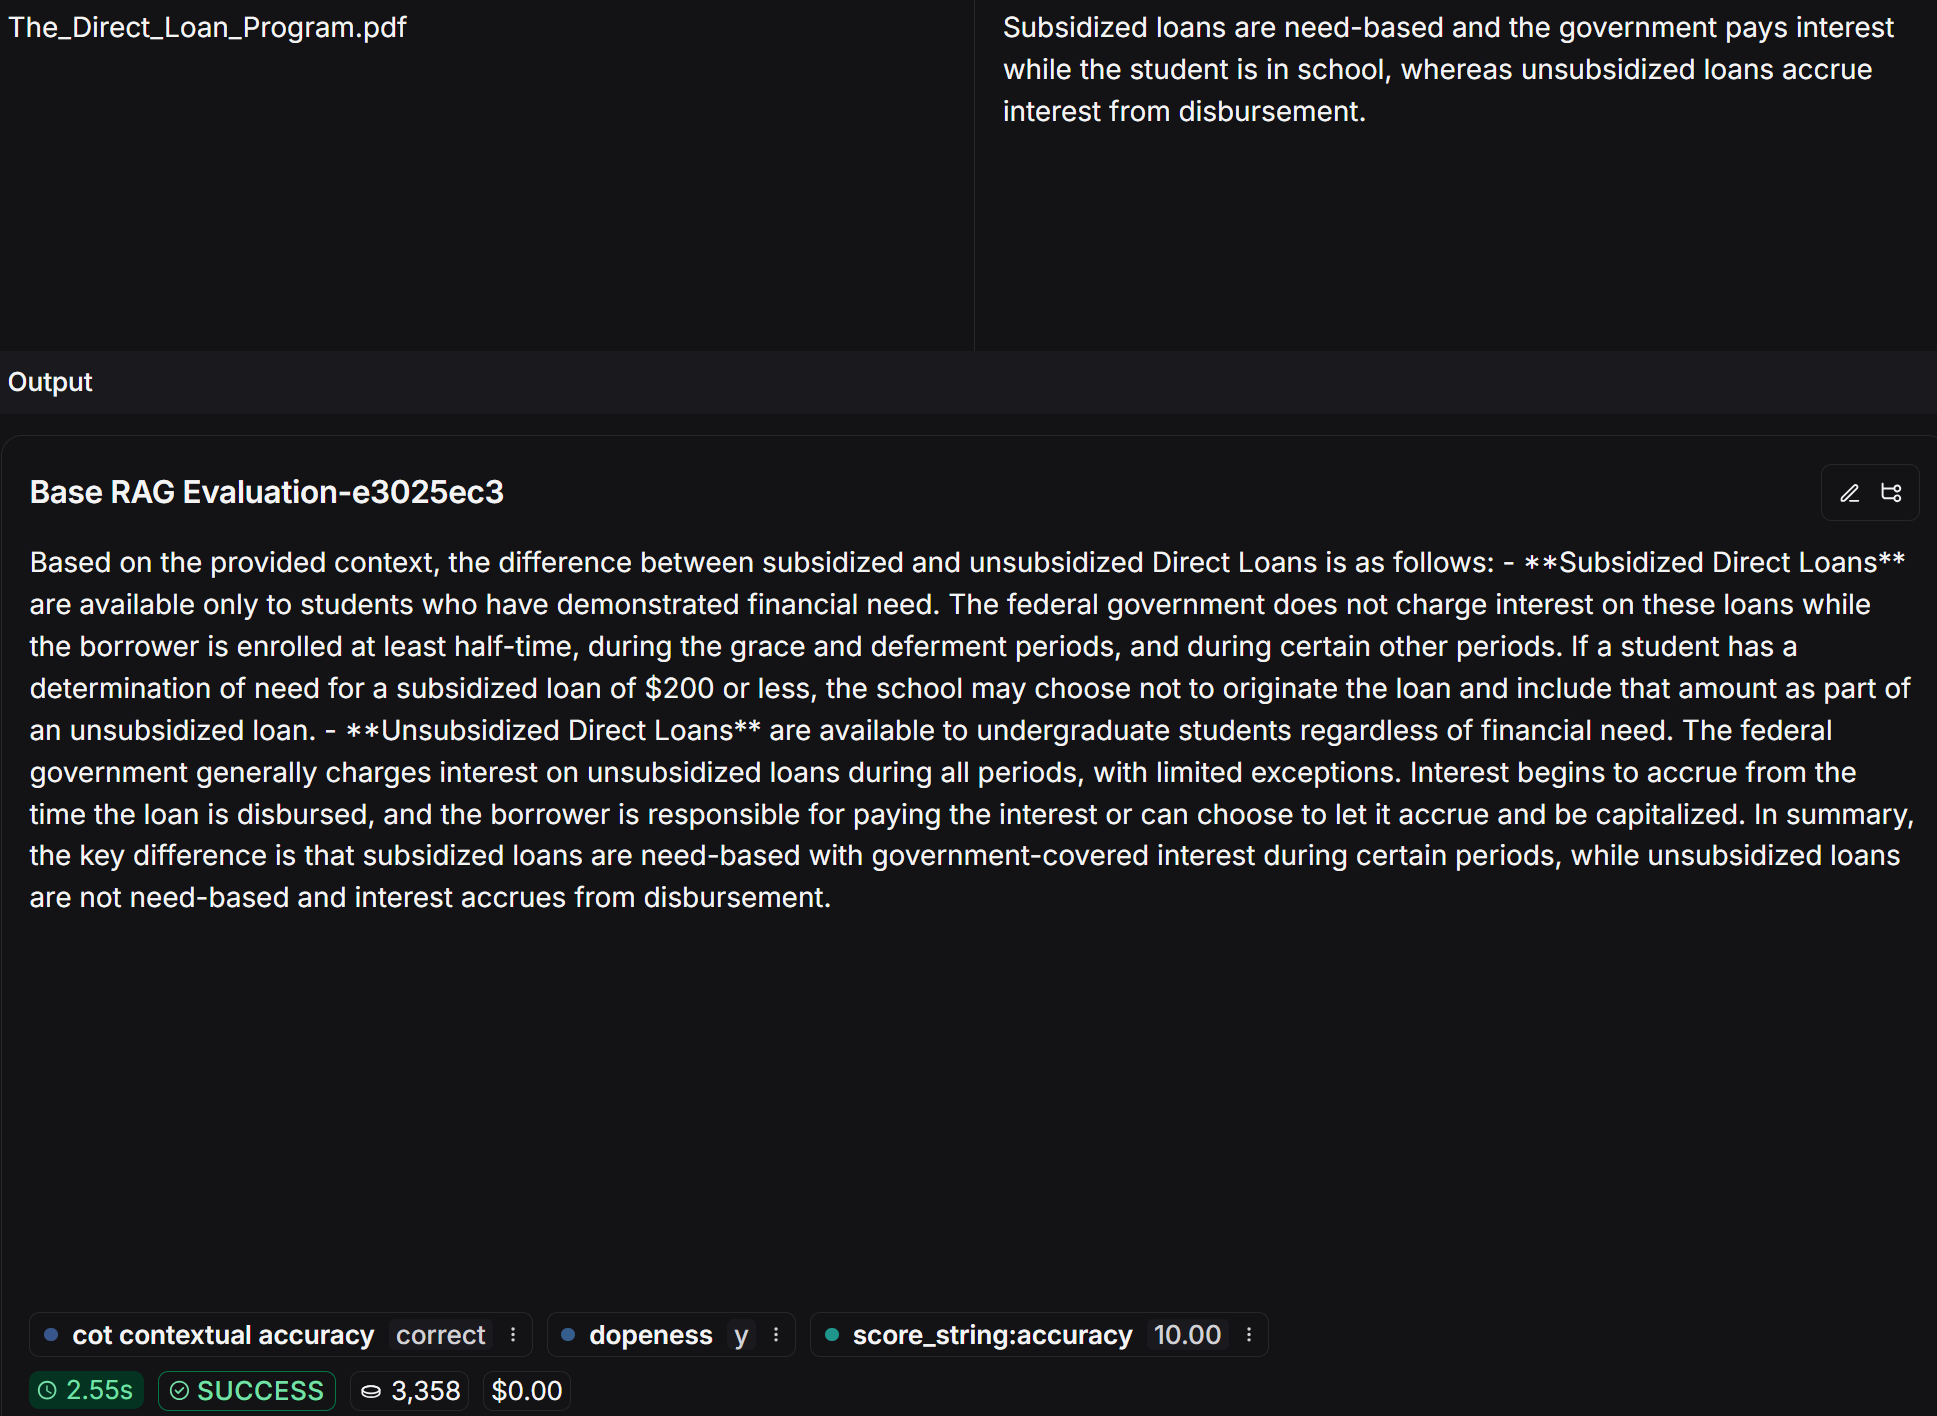 -->
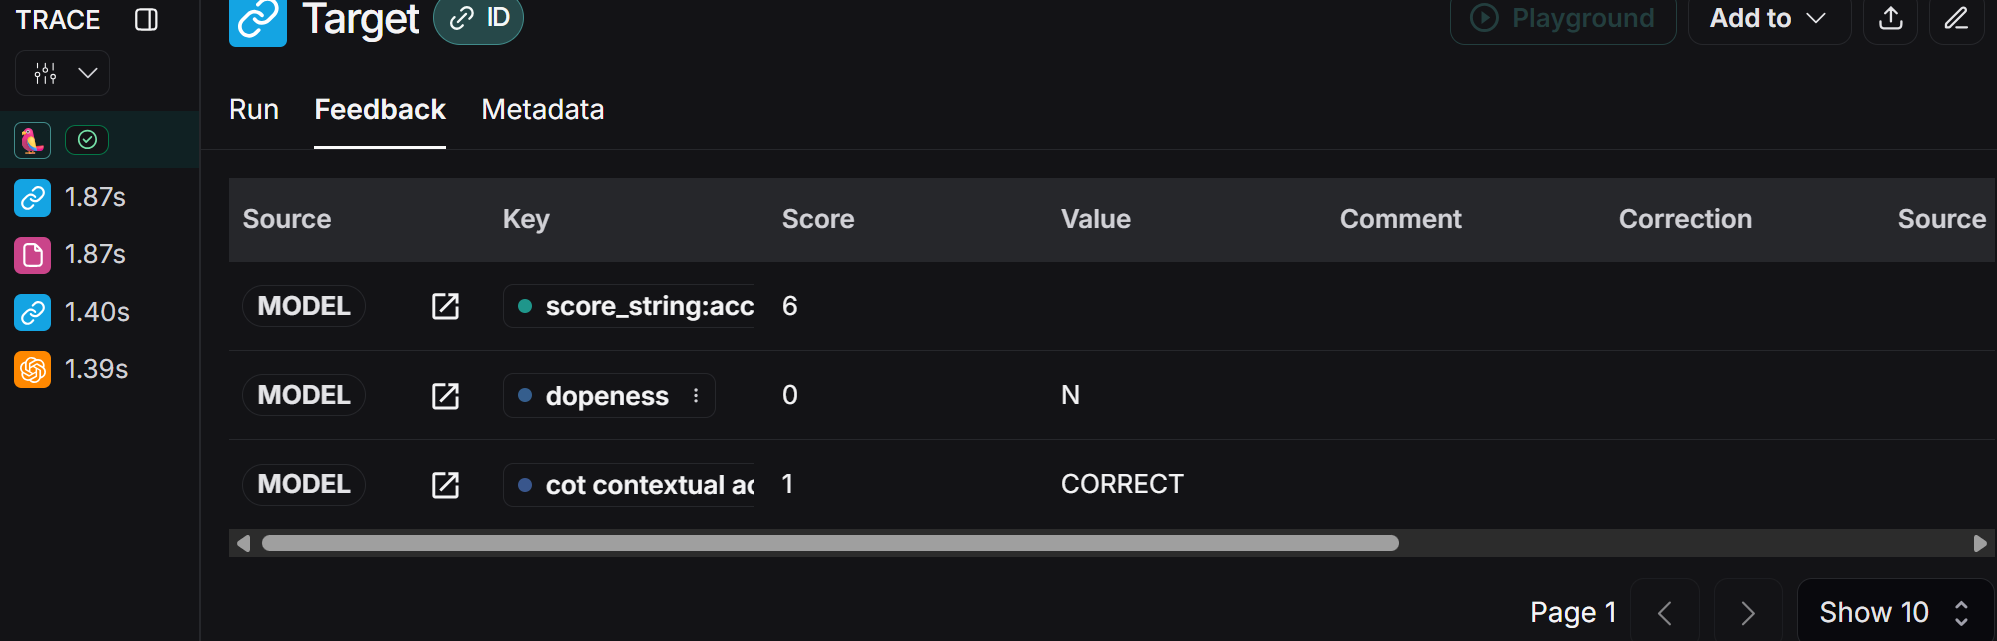
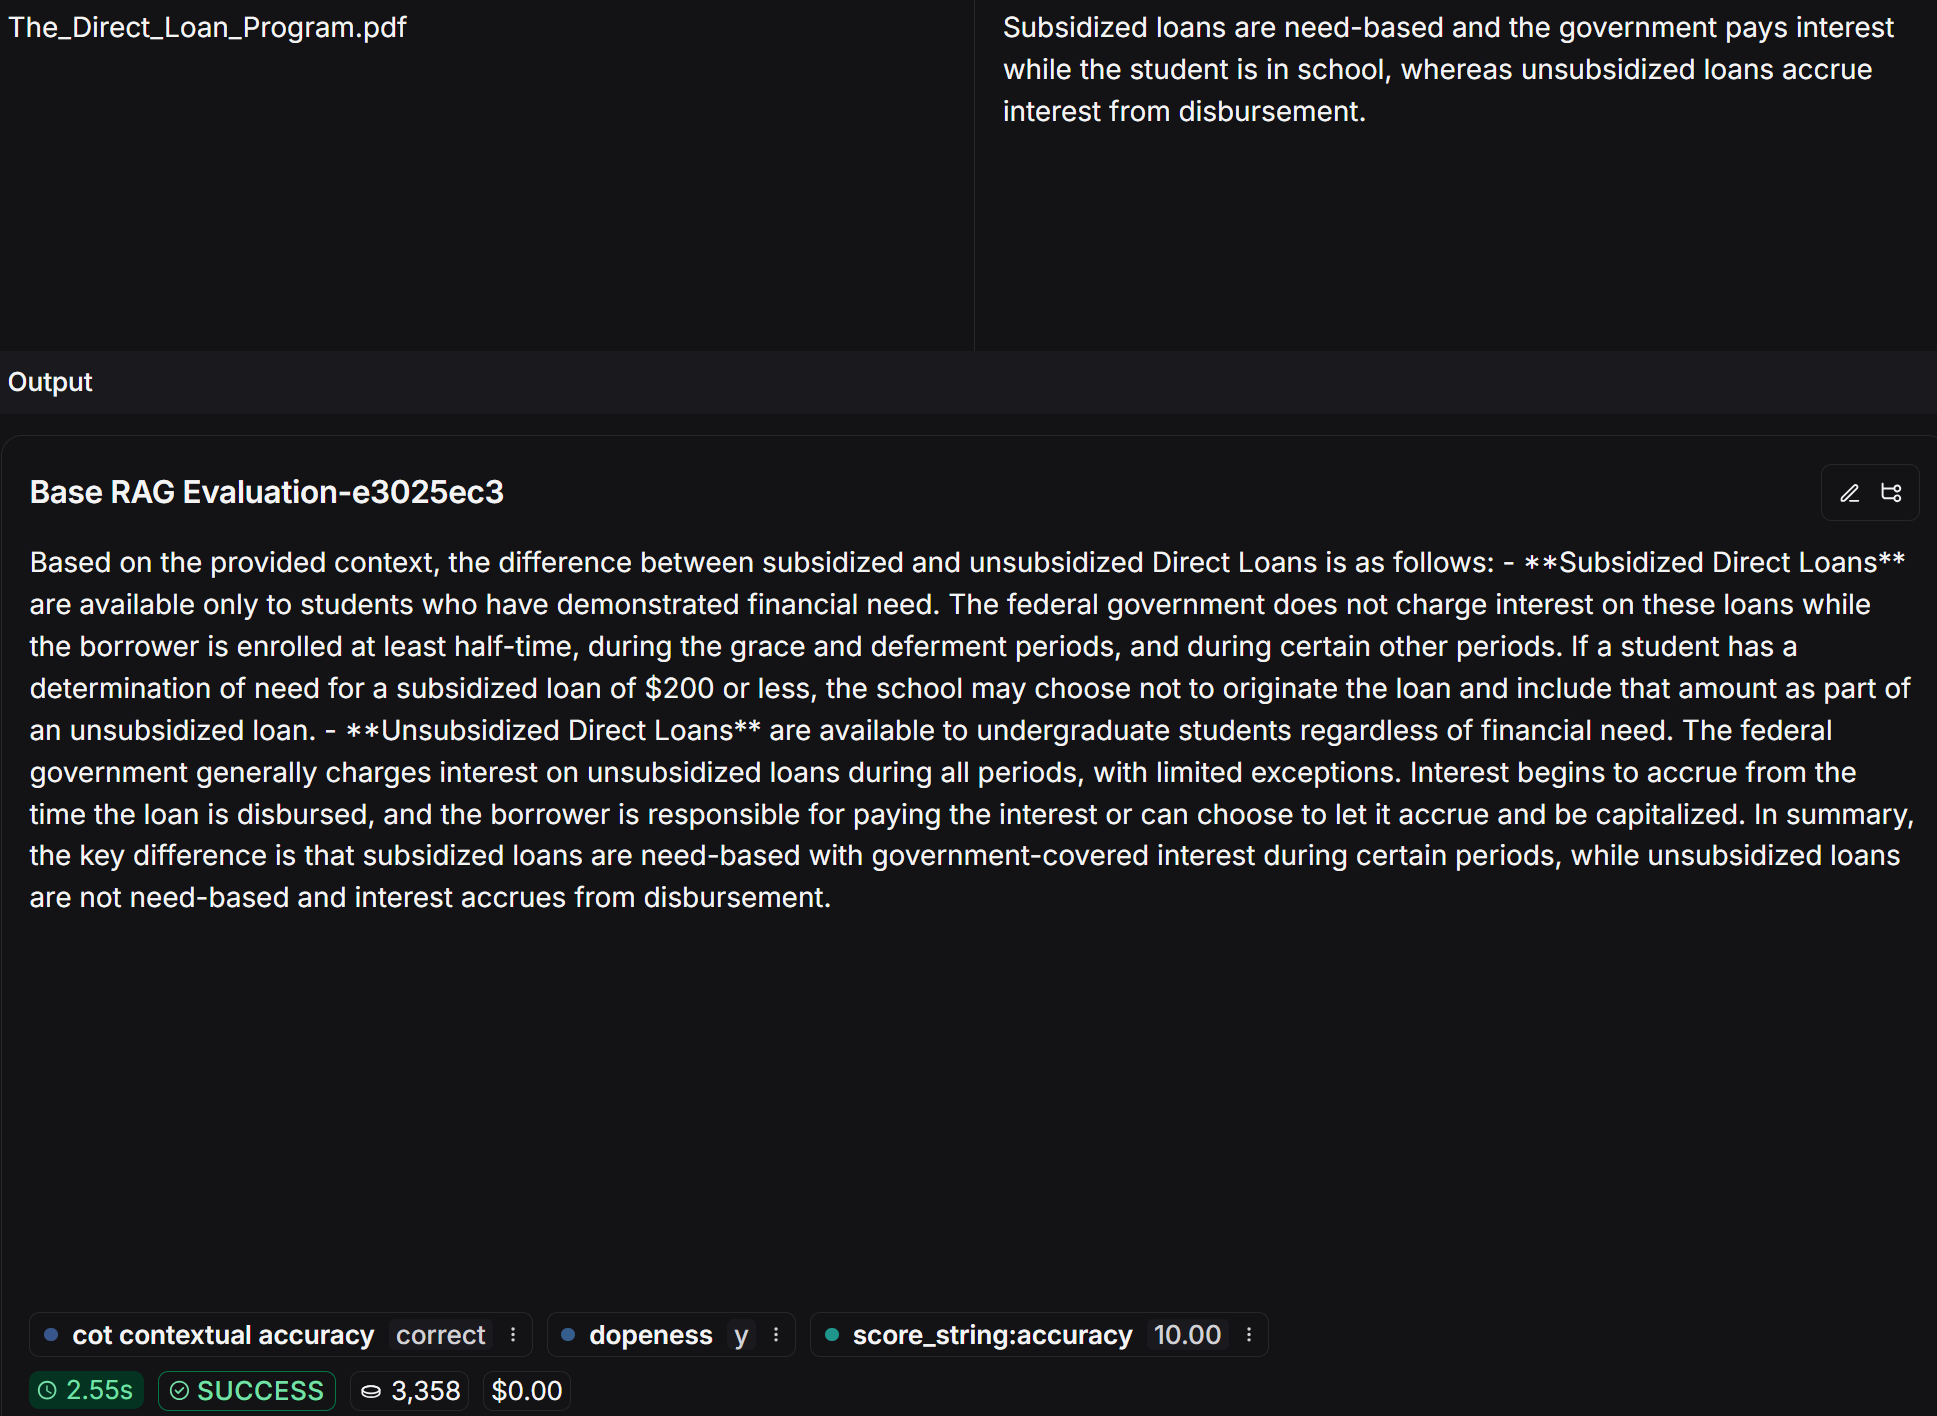

We see the scores for the 3 evaluation parameters that we asked it to eval.

## Task 5: Loading Our Testing Set

In [27]:
!git clone https://github.com/AI-Maker-Space/DataRepository.git

Cloning into 'DataRepository'...
remote: Enumerating objects: 122, done.
remote: Counting objects: 100% (114/114), done.
remote: Compressing objects: 100% (99/99), done.
remote: Total 122 (delta 37), reused 39 (delta 10), pack-reused 8 (from 1)
Receiving objects: 100% (122/122), 78.04 MiB | 30.52 MiB/s, done.
Resolving deltas: 100% (37/37), done.


In [29]:
import pandas as pd

test_df = pd.read_csv("DataRepository/student_loan_rag_test_data.csv")

Now we can set up our LangSmith client - and we'll add the above created dataset to our LangSmith instance!

> NOTE: Read more about this process [here](https://docs.smith.langchain.com/old/evaluation/faq/manage-datasets#create-from-list-of-values)

In [ ]:
from langsmith import Client

client = Client()

dataset_name = "langsmith-student-loan-rag"

dataset = client.create_dataset(
    dataset_name=dataset_name, description="Student Loan RAG Test Questions"
)

for triplet in test_df.iterrows():
  triplet = triplet[1]
  client.create_example(
      inputs={"question" : triplet["question"], "context": triplet["context"]},
      outputs={"answer" : triplet["answer"]},
      dataset_id=dataset.id
  )

## Task 6: Evaluation

Now we can run the evaluation!

We'll need to start by preparing some custom data preparation functions to ensure our chain works with the expected inputs/outputs from the `evaluate` process in LangSmith.

> NOTE: More reading on this available [here](https://docs.smith.langchain.com/how_to_guides/evaluation/evaluate_llm_application#evaluate-a-langchain-runnable)

In [32]:
def prepare_data_ref(run, example):
  return {
      "prediction" : run.outputs["response"],
      "reference" : example.outputs["answer"],
      "input" : example.inputs["question"]
  }

def prepare_data_noref(run, example):
  return {
      "prediction" : run.outputs["response"],
      "input" : example.inputs["question"]
  }

def prepare_context_ref(run, example):
  return {
      "prediction" : run.outputs["response"],
      "reference" : example.inputs["context"],
      "input" : example.inputs["question"]
  }

We'll be using a few custom evaluators to evaluate our pipeline, as well as a few "built in" methods!

Check out the built-ins [here](https://docs.smith.langchain.com/reference/sdk_reference/langchain_evaluators)!

In [33]:
from langsmith.evaluation import LangChainStringEvaluator, evaluate

eval_llm = ChatOpenAI(model="gpt-4o-mini", tags=["eval_llm"])

cot_qa_evaluator = LangChainStringEvaluator("cot_qa",  config={"llm":eval_llm}, prepare_data=prepare_context_ref)

unlabeled_dopeness_evaluator = LangChainStringEvaluator(
    "criteria",
    config={
        "criteria" : {
            "dopeness" : "Is the answer to the question dope, meaning cool - awesome - and legit?"
        },
        "llm" : eval_llm,
    },
    prepare_data=prepare_data_noref
)

labeled_score_evaluator = LangChainStringEvaluator(
    "labeled_score_string",
    config={
        "criteria": {
            "accuracy": "Is the generated answer the same as the reference answer?"
        },
    },
    prepare_data=prepare_data_ref
)

base_rag_results = evaluate(
    rag_graph.invoke,
    data=dataset_name,
    evaluators=[
        cot_qa_evaluator,
        unlabeled_dopeness_evaluator,
        labeled_score_evaluator,
        ],
    experiment_prefix="Base RAG Evaluation"
)

View the evaluation results for experiment: 'Base RAG Evaluation-e3025ec3' at:
https://smith.langchain.com/o/74b9e486-2e11-541b-b227-c9c177f98636/datasets/06fe7c80-7205-459a-a212-e2264b0a06c4/compare?selectedSessions=17e5389e-1bec-4498-9239-c83bf3f64e90




0it [00:00, ?it/s]

#### ❓Question #1:

What conclusions can you draw about the above results?

Describe in your own words what the metrics are expressing.

Above I included 2 images of results from 2 different querries  
The parameters that langsmith are: 
* Chain of Thought (Cot) 🦜evaluate COT Contextual Accuracy 6.38s  CotQAEvalChain 6.38s ChatOpenAI gpt-4o-mini 6.38s
   *  It results from the prompt: "step by step"
   *  It questions:
   *  * Is the final answer faithful to the given context?
   *  * Did the model only use the provided sources (retrieved docs or instructions)?
   *  * Are intermediate steps also consistent with context?
*  score_string:accuracy: 10.00
*  dopeness: we defined it in the code:
    * "dopeness" : "Is the answer to the question dope, meaning cool - awesome - and legit?"
